In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set matplotlib style
plt.style.use('ggplot')


In [2]:
# Download and extract the GTSRB dataset
!wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

--2025-09-09 08:50:30--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  38.6MB/s    in 7.7s    

2025-09-09 08:50:38 (34.3 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2025-09-09 08:50:38--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

In [3]:

# Unzip the files
!unzip -q -o GTSRB_Final_Training_Images.zip
!unzip -q -o GTSRB_Final_Test_Images.zip
!unzip -q -o GTSRB_Final_Test_GT.zip

In [4]:
"""## Data Loading and Exploration"""

# Define paths
TRAIN_PATH = "GTSRB/Final_Training/Images"
TEST_PATH = "GTSRB/Final_Test/Images"
TEST_CSV_PATH = "GT-final_test.csv"

In [5]:
# Load class names
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

In [6]:
# Function to load training data
def load_training_data(data_path):
    images = []
    labels = []

    # Iterate through all class folders
    for class_id in range(43):
        class_path = os.path.join(data_path, format(class_id, '05d'))
        csv_file = os.path.join(class_path, f"GT-{format(class_id, '05d')}.csv")

        # Read CSV file for this class
        data = pd.read_csv(csv_file, sep=';')

        for _, row in data.iterrows():
            img_path = os.path.join(class_path, row['Filename'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

            # Get ROI from image
            x1, y1 = row['Roi.X1'], row['Roi.Y1']
            x2, y2 = row['Roi.X2'], row['Roi.Y2']
            image = image[y1:y2, x1:x2]

            images.append(image)
            labels.append(class_id)

    return images, labels

In [7]:
# Function to load test data
def load_test_data(test_images_path, test_csv_path):
    images = []
    labels = []

    # Read test CSV
    test_data = pd.read_csv(test_csv_path, sep=';')

    for _, row in test_data.iterrows():
        img_path = os.path.join(test_images_path, row['Filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Get ROI from image
        x1, y1 = row['Roi.X1'], row['Roi.Y1']
        x2, y2 = row['Roi.X2'], row['Roi.Y2']
        image = image[y1:y2, x1:x2]

        images.append(image)
        labels.append(row['ClassId'])

    return images, labels

In [8]:
# Load the data
print("Loading training data...")
train_images, train_labels = load_training_data(TRAIN_PATH)

print("Loading test data...")
test_images, test_labels = load_test_data(TEST_PATH, TEST_CSV_PATH)

print(f"Training data: {len(train_images)} images")
print(f"Test data: {len(test_images)} images")

Loading training data...
Loading test data...
Training data: 39209 images
Test data: 12630 images


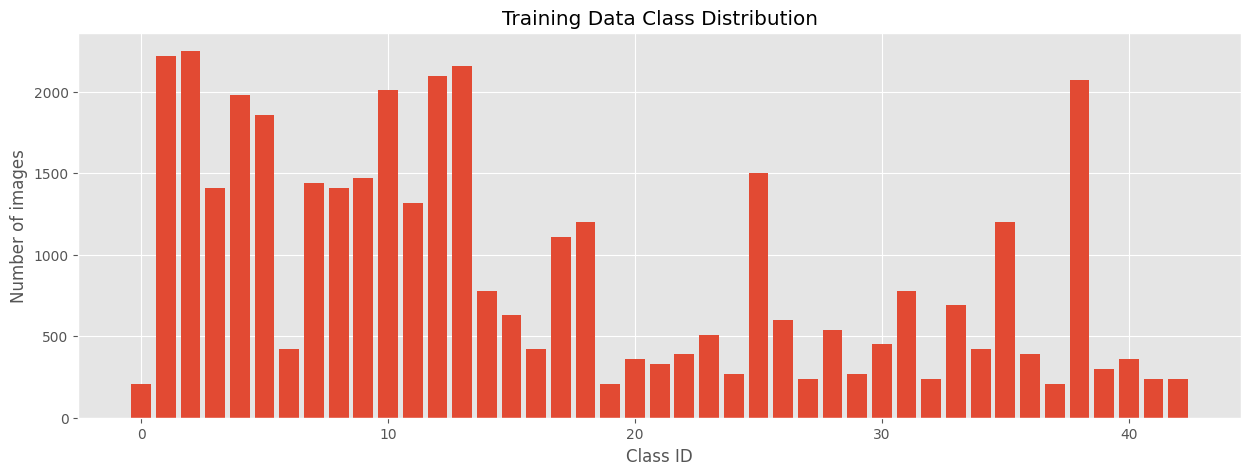

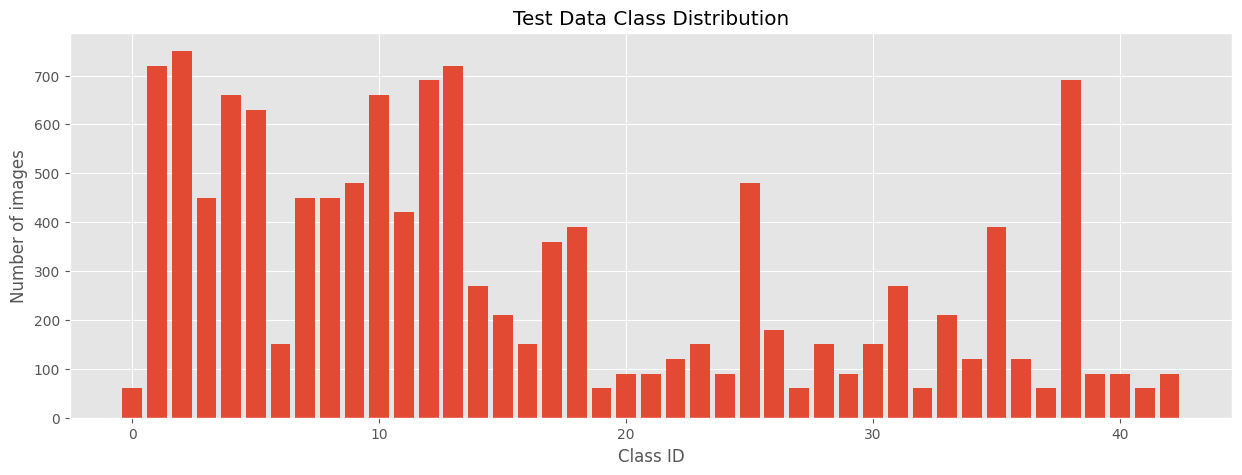

In [9]:
# Display class distribution
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(15, 5))
    plt.bar(unique, counts)
    plt.title(title)
    plt.xlabel('Class ID')
    plt.ylabel('Number of images')
    plt.show()

plot_class_distribution(train_labels, 'Training Data Class Distribution')
plot_class_distribution(test_labels, 'Test Data Class Distribution')

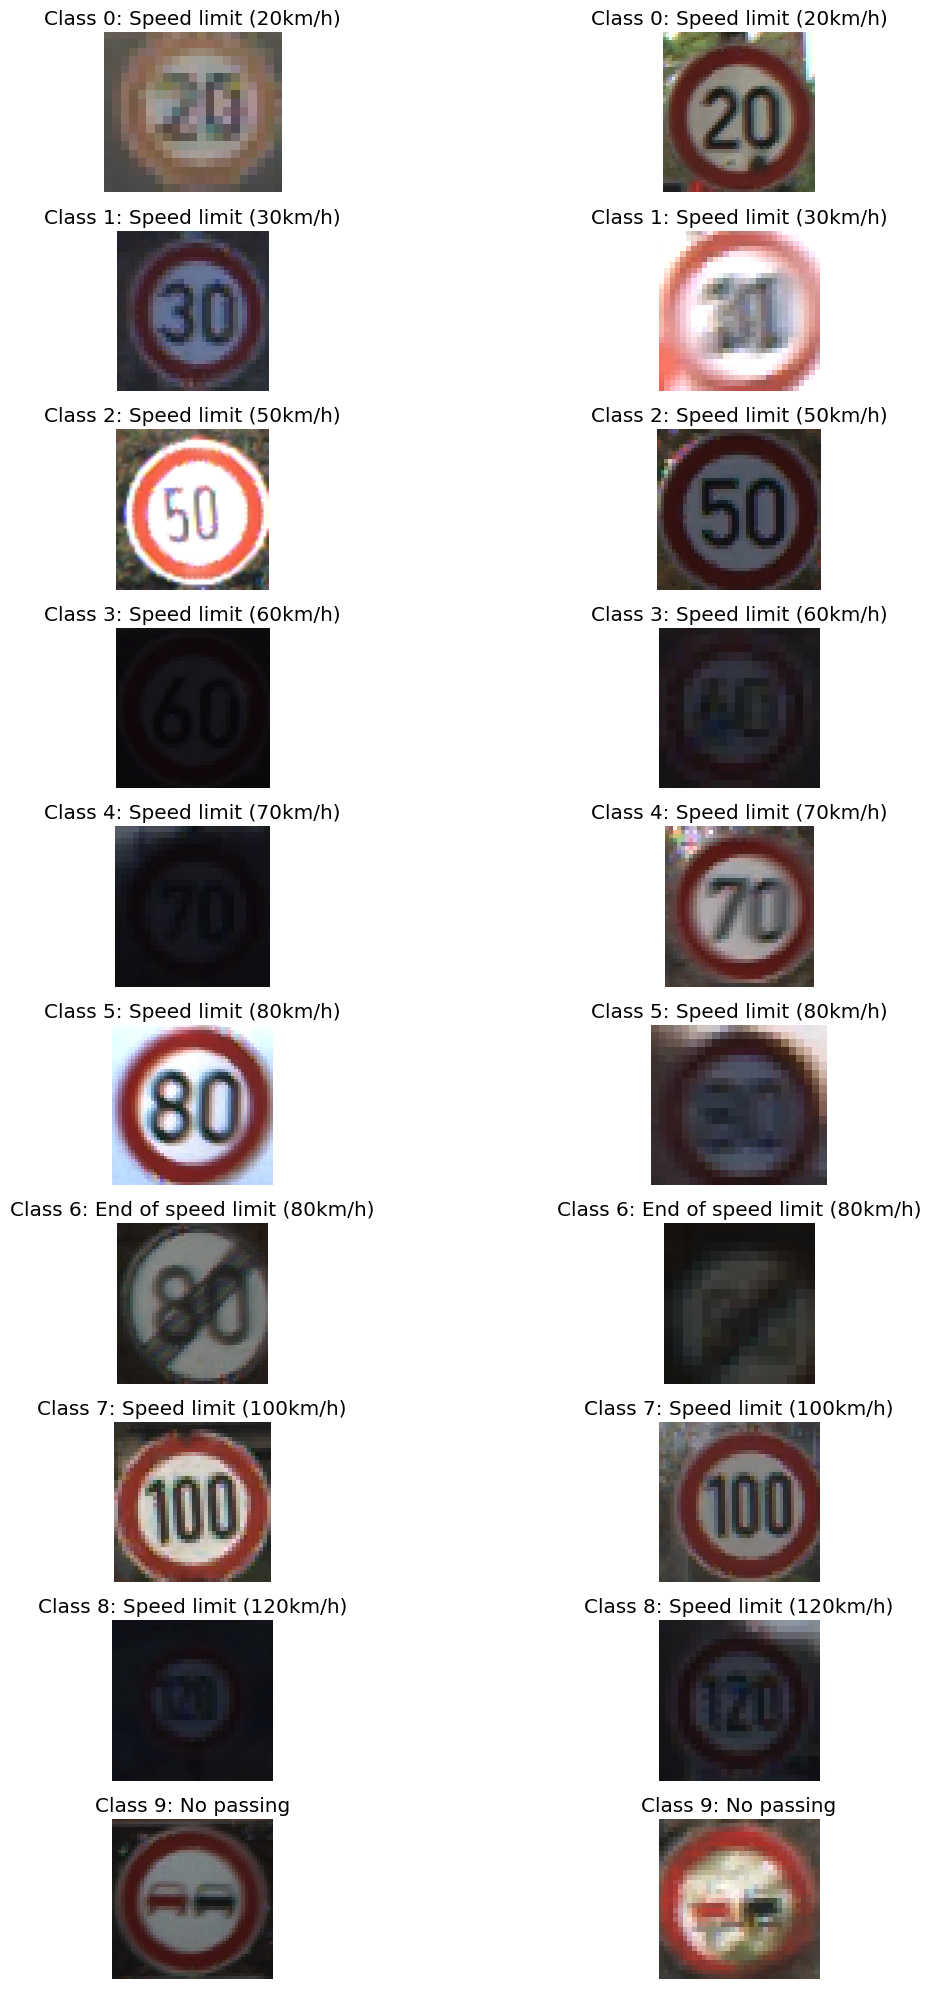

In [10]:
# Display sample images from each class
def display_sample_images(images, labels, class_names, num_classes=43, samples_per_class=1):
    plt.figure(figsize=(15, 20))

    for class_id in range(num_classes):
        class_indices = [i for i, label in enumerate(labels) if label == class_id]

        if not class_indices:
            continue

        sample_indices = random.sample(class_indices, min(samples_per_class, len(class_indices)))

        for i, idx in enumerate(sample_indices):
            plt_idx = class_id * samples_per_class + i + 1
            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(images[idx])
            plt.title(f"Class {class_id}: {class_names[class_id]}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_images, train_labels, class_names, num_classes=10, samples_per_class=2)

In [11]:
"""## Data Preprocessing"""

# Function to preprocess images
def preprocess_images(images, target_size=(32, 32)):
    processed_images = []

    for img in images:
        # Resize image
        img_resized = cv2.resize(img, target_size)

        # Normalize pixel values to [0, 1]
        img_normalized = img_resized / 255.0

        processed_images.append(img_normalized)

    return np.array(processed_images)


In [12]:
# Preprocess training and test images
print("Preprocessing training images...")
X_train = preprocess_images(train_images)
y_train = np.array(train_labels)

print("Preprocessing test images...")
X_test = preprocess_images(test_images)
y_test = np.array(test_labels)

# Convert labels to categorical (one-hot encoding)
num_classes = 43
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test_categorical.shape}")

Preprocessing training images...
Preprocessing test images...
Training data shape: (39209, 32, 32, 3)
Training labels shape: (39209, 43)
Test data shape: (12630, 32, 32, 3)
Test labels shape: (12630, 43)


In [13]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train_categorical, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 31367 samples
Validation set: 7842 samples
Test set: 12630 samples


In [14]:
"""## Data Augmentation"""

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,  # Traffic signs shouldn't be flipped horizontally
    fill_mode='nearest'
)

# Fit the data generator
datagen.fit(X_train)


In [15]:
# Visualize augmented images
def visualize_augmentation(datagen, images, num_samples=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title('Original')
        plt.axis('off')


         # Augmented image
        plt.subplot(2, num_samples, i + 1 + num_samples)
        augmented = datagen.random_transform(images[i])
        plt.imshow(augmented)
        plt.title('Augmented')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


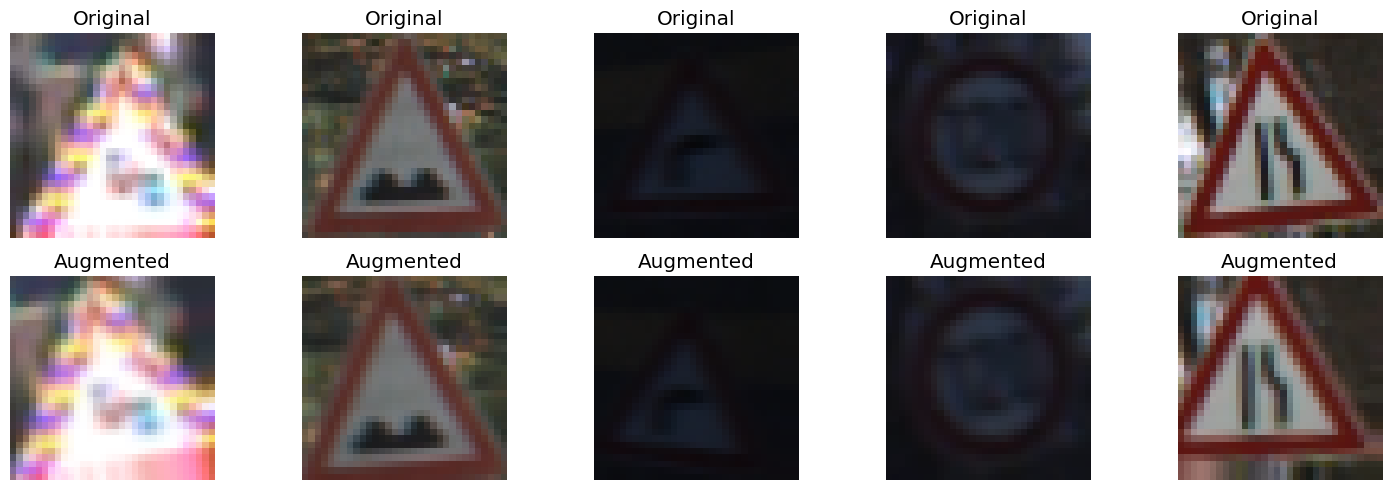

In [16]:
# Visualize augmentation on sample images
sample_indices = np.random.choice(len(X_train), 5, replace=False)
sample_images = X_train[sample_indices]
visualize_augmentation(datagen, sample_images)


In [17]:
"""## Build Custom CNN Model"""

def create_custom_cnn(input_shape=(32, 32, 3), num_classes=43):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the model
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
custom_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,483,339 (5.66 MB)

 Trainable params: 1,480,907 (5.65 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [19]:
"""## Train Custom CNN Model"""

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history_custom = custom_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 291s 594ms/step - accuracy: 0.9222 - loss: 0.2583 - val_accuracy: 0.9894 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 2/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 1.0000 - loss: 0.1016 - val_accuracy: 0.9897 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 3/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 288s 589ms/step - accuracy: 0.9596 - loss: 0.1368 - val_accuracy: 0.9957 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 4/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 1.0000 - loss: 0.0222 - val_accuracy: 0.9954 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 5/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 301s 589ms/step - accuracy: 0.9600 - loss: 0.1327 - val_accuracy: 0.9968 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 6/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9844 - loss: 0.0618 - val_accuracy: 0.9968 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 7/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 294s 574ms/step - accuracy: 0.

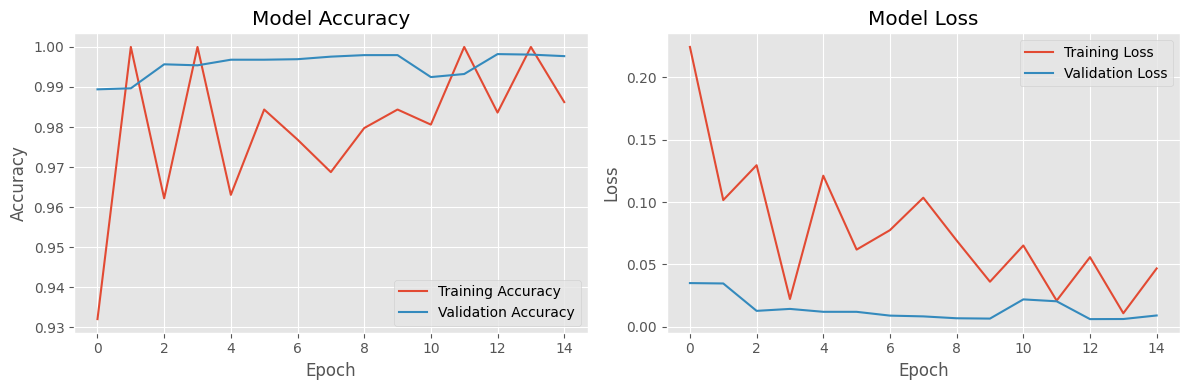

Custom CNN Test Accuracy: 0.9819
Custom CNN Test Loss: 0.0698
395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step


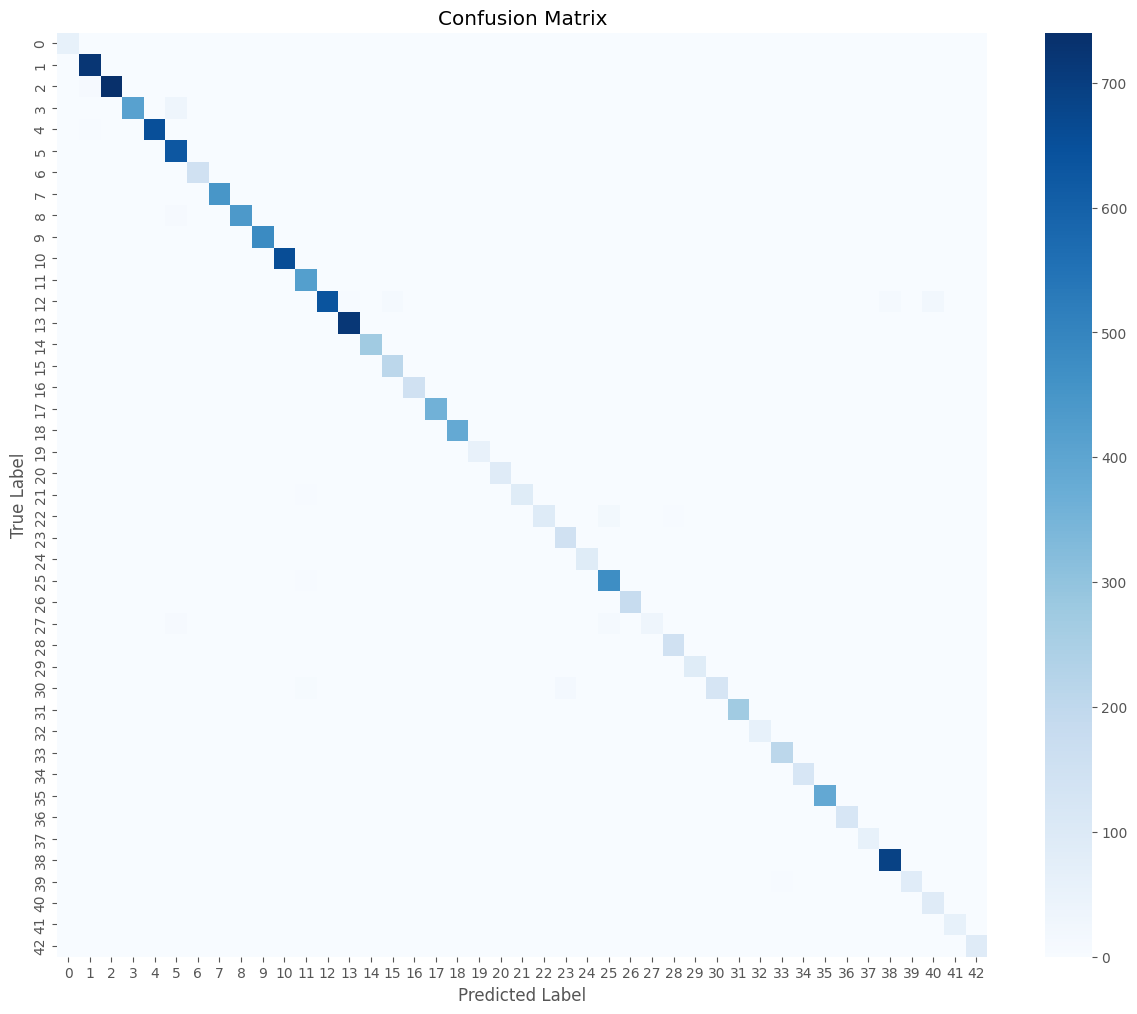

Classification Report:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.97      1.00      0.98        60
                              Speed limit (30km/h)       0.98      1.00      0.99       720
                              Speed limit (50km/h)       1.00      0.99      0.99       750
                              Speed limit (60km/h)       1.00      0.92      0.96       450
                              Speed limit (70km/h)       1.00      0.99      0.99       660
                              Speed limit (80km/h)       0.91      1.00      0.95       630
                       End of speed limit (80km/h)       1.00      0.99      1.00       150
                             Speed limit (100km/h)       1.00      1.00      1.00       450
                             Speed limit (120km/h)       1.00      0.98      0.99       450
                                        No passing      

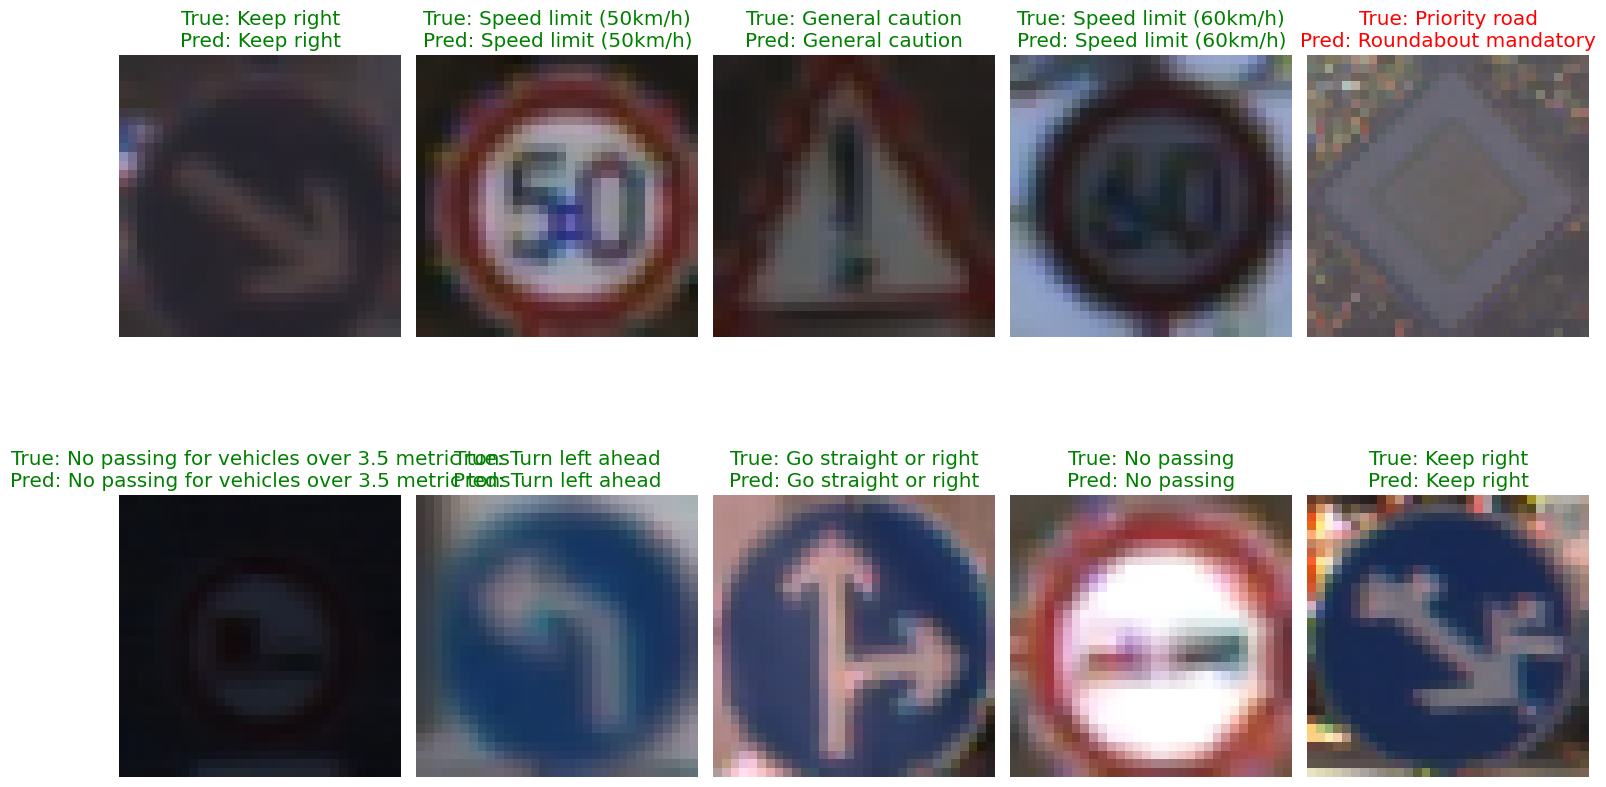

In [20]:
"""## Evaluate Custom CNN Model"""

# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_custom)

# Evaluate on test set
test_loss, test_accuracy = custom_cnn.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Custom CNN Test Accuracy: {test_accuracy:.4f}")
print(f"Custom CNN Test Loss: {test_loss:.4f}")

# Predict on test set
y_pred = custom_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=range(43), yticklabels=range(43))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[class_names[i] for i in range(43)]))

# Display some test predictions
def display_test_predictions(images, true_labels, pred_labels, class_names, num_samples=10):
    plt.figure(figsize=(15, 10))

    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])

        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]

        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.title(f'True: {true_class}\nPred: {pred_class}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_test_predictions(X_test, y_test, y_pred_classes, class_names)

/tmp/ipython-input-1461812776.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,011 (9.26 MB)

 Trainable params: 169,771 (663.17 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - accuracy: 0.1020 - loss: 3.7980 - val_accuracy: 0.2742 - val_loss: 2.6101 - learning_rate: 0.0010
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1406 - loss: 3.2880 - val_accuracy: 0.2737 - val_loss: 2.6095 - learning_rate: 0.0010
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - accuracy: 0.1797 - loss: 2.9407 - val_accuracy: 0.2813 - val_loss: 2.4604 - learning_rate: 0.0010
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1875 - loss: 3.0373 - val_accuracy: 0.2805 - val_loss: 2.4604 - learning_rate: 0.0010
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - accuracy: 0.2016 - loss: 2.7863 - val_accuracy: 0.2935 - val_loss: 2.4321 - learning_rate: 0.0010
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1875 - loss: 2.5770 - val_accuracy: 0.2942 - val_loss: 2.4320 - learning_rate: 0.0010
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.2091 - lo

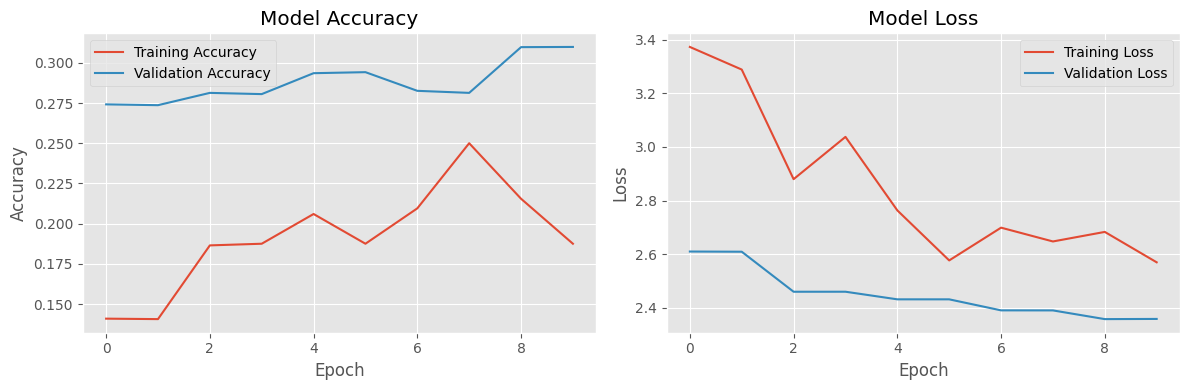

MobileNet Test Accuracy: 0.2750
MobileNet Test Loss: 2.4531
Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 128s 228ms/step - accuracy: 0.1752 - loss: 3.0339 - val_accuracy: 0.1067 - val_loss: 3.1622 - learning_rate: 1.0000e-04
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4375 - loss: 1.9183 - val_accuracy: 0.1066 - val_loss: 3.1616 - learning_rate: 1.0000e-04
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 133s 224ms/step - accuracy: 0.3680 - loss: 2.0397 - val_accuracy: 0.1850 - val_loss: 2.8531 - learning_rate: 1.0000e-04
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5156 - loss: 1.5203 - val_accuracy: 0.1849 - val_loss: 2.8529 - learning_rate: 1.0000e-04
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 109s 223ms/step - accuracy: 0.4708 - loss: 1.6821 - val_accuracy: 0.2698 - val_loss: 2.6395 - learning_rate: 1.0000e-04
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4844 - loss: 1.5730 - val_accuracy: 0.2692 - val_loss: 2.6407 - learning_rate

In [23]:
"""## Pre-trained Model (MobileNetV2)"""

def create_mobilenet_model(input_shape=(32, 32, 3), num_classes=43):
    # Load pre-trained MobileNetV2 without top layers
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom top layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile MobileNet model
mobilenet = create_mobilenet_model()
mobilenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet.summary()

# Train MobileNet model
history_mobilenet = mobilenet.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history for MobileNet
plot_training_history(history_mobilenet)

# Evaluate MobileNet on test set
test_loss_mobilenet, test_accuracy_mobilenet = mobilenet.evaluate(X_test, y_test_categorical, verbose=0)
print(f"MobileNet Test Accuracy: {test_accuracy_mobilenet:.4f}")
print(f"MobileNet Test Loss: {test_loss_mobilenet:.4f}")

# Fine-tuning: Unfreeze some layers
def fine_tune_model(model):
    # Unfreeze the top layers of the base model
    model.layers[0].trainable = True

    # Freeze the first 100 layers
    for layer in model.layers[0].layers[:100]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Fine-tune the MobileNet model
mobilenet = fine_tune_model(mobilenet)

# Continue training with fine-tuning
history_mobilenet_ft = mobilenet.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate fine-tuned MobileNet
test_loss_mobilenet_ft, test_accuracy_mobilenet_ft = mobilenet.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Fine-tuned MobileNet Test Accuracy: {test_accuracy_mobilenet_ft:.4f}")
print(f"Fine-tuned MobileNet Test Loss: {test_loss_mobilenet_ft:.4f}")


In [24]:
"""## Model Comparison"""

# Compare model performance
models_comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNet (Frozen)', 'MobileNet (Fine-tuned)'],
    'Test Accuracy': [test_accuracy, test_accuracy_mobilenet, test_accuracy_mobilenet_ft],
    'Test Loss': [test_loss, test_loss_mobilenet, test_loss_mobilenet_ft]
})

print(models_comparison)

                    Model  Test Accuracy  Test Loss
0              Custom CNN       0.981948   0.069839
1      MobileNet (Frozen)       0.274980   2.453074
2  MobileNet (Fine-tuned)       0.465162   1.730827


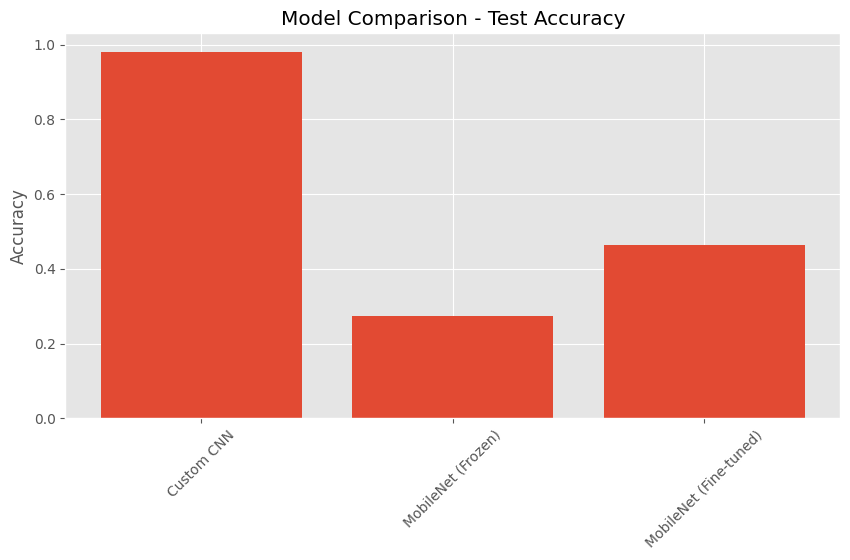

In [25]:
# Plot comparison
plt.figure(figsize=(10, 5))
plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'])
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Save the models
custom_cnn.save('traffic_sign_custom_cnn.h5')
mobilenet.save('traffic_sign_mobilenet.h5')

print("Models saved successfully!")

# Download the models
from google.colab import files
files.download('traffic_sign_custom_cnn.h5')
files.download('traffic_sign_mobilenet.h5')

Models saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Display final results
print("=== FINAL RESULTS ===")
print(f"Custom CNN Accuracy: {test_accuracy:.4f}")
print(f"MobileNet Accuracy (Frozen): {test_accuracy_mobilenet:.4f}")
print(f"MobileNet Accuracy (Fine-tuned): {test_accuracy_mobilenet_ft:.4f}")

=== FINAL RESULTS ===
Custom CNN Accuracy: 0.9819
MobileNet Accuracy (Frozen): 0.2750
MobileNet Accuracy (Fine-tuned): 0.4652
